In [1]:
import pandas as pd
import pickle
import os

import autorank
import matplotlib.pyplot as plt

import seaborn as sns
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt

from dieboldmariano import dm_test

In [2]:
# --- CONFIGURAÇÕES GLOBAIS ---

MODEL_NAMES = [
    'HyS-MF',
    'HyS-MF_MIMO',
    'ARIMA-MLP',
    'ARIMA-LSTM',
    'PureARIMA',
    'PureLSTM',
    'PureNBEATS'
]
DATASET_NAMES = [
    'AirPassengers', 'Nile', 'Sunspots','UKgas', 'ukdriverdeaths'
]
FORECAST_HORIZON = 10

# Caminhos para os resultados
METRICS_PATH = 'results/metrics/'
PREDICTIONS_PATH = 'results/predictions/'

# Estilo visual para os gráficos
sns.set_style("whitegrid")
print("Ambiente de análise configurado com sucesso!")

Ambiente de análise configurado com sucesso!


In [3]:
all_metrics = []
for ds_name in DATASET_NAMES:
    row = {'Dataset': ds_name}
    for model_name in MODEL_NAMES:
        file_path = os.path.join(METRICS_PATH, f"{ds_name}_{model_name}.pkl")
        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                metrics = pickle.load(f)
                row[model_name] = metrics
    all_metrics.append(row)

# Criar um DataFrame base com as métricas
df_metrics = pd.DataFrame(all_metrics).set_index('Dataset')

# --- Tabela de MAPE ---
df_mape = df_metrics.map(lambda x: x.get('MAPE') if isinstance(x, dict) else None)
print("Tabela de Resultados: Mean Absolute Percentage Error (MAPE)")
display(df_mape.style.highlight_min(axis=1, color='blue').format("{:.2f}"))

# --- Tabela de MASE ---
df_mase = df_metrics.map(lambda x: x.get('MASE') if isinstance(x, dict) else None)
print("\nTabela de Resultados: Mean Absolute Scaled Error (MASE)")
display(df_mase.style.highlight_min(axis=1, color='blue').format("{:.3f}"))

Tabela de Resultados: Mean Absolute Percentage Error (MAPE)


,HyS-MF,HyS-MF_MIMO,ARIMA-MLP,ARIMA-LSTM,PureARIMA,PureLSTM,PureNBEATS
Dataset,,,,,,,
AirPassengers,8.52,8.17,8.40,7.56,3.23,15.03,6.45
Nile,14.95,16.60,18.36,13.92,13.66,13.51,14.86
Sunspots,145.92,147.83,169.53,190.19,172.77,155.89,101.57
UKgas,7.92,7.32,9.42,6.98,8.76,51.57,11.56
ukdriverdeaths,13.11,12.34,16.27,14.75,6.39,19.88,6.13



Tabela de Resultados: Mean Absolute Scaled Error (MASE)


,HyS-MF,HyS-MF_MIMO,ARIMA-MLP,ARIMA-LSTM,PureARIMA,PureLSTM,PureNBEATS
Dataset,,,,,,,
AirPassengers,1.737,1.685,1.708,1.603,0.618,3.369,1.378
Nile,0.980,1.082,1.186,0.938,0.892,0.850,1.005
Sunspots,0.590,0.592,0.576,0.701,0.651,0.585,0.684
UKgas,0.329,0.309,0.383,0.304,0.342,1.671,0.413
ukdriverdeaths,1.151,1.105,1.431,1.332,0.539,1.463,0.495


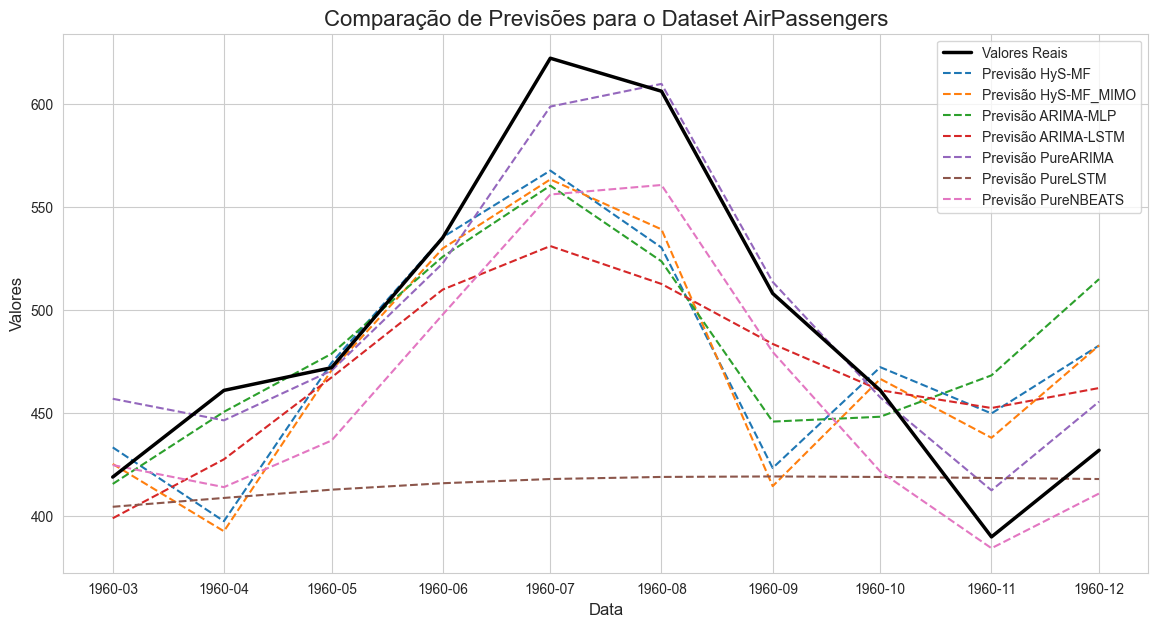

In [4]:
DS_TO_PLOT = 'AirPassengers'

try:
    full_series_df = pd.read_csv(f"datasets/{DS_TO_PLOT}.csv", index_col=0, parse_dates=True)
    test_series = full_series_df[-FORECAST_HORIZON:].squeeze().rename('Valores Reais')

    # Plotar os dados reais de teste
    plt.figure(figsize=(14, 7))
    plt.plot(test_series.index, test_series.values, label='Valores Reais', color='black', linewidth=2.5, zorder=10)

    # Plotar as previsões de cada modelo
    for model_name in MODEL_NAMES:
        file_path = os.path.join(PREDICTIONS_PATH, f"{DS_TO_PLOT}_{model_name}.csv")
        if os.path.exists(file_path):
            pred_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            plt.plot(pred_df.index, pred_df['prediction'], label=f'Previsão {model_name}', linestyle='--')

    plt.title(f'Comparação de Previsões para o Dataset {DS_TO_PLOT}', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Dataset '{DS_TO_PLOT}.csv' não encontrado na pasta 'datasets/'. Verifique o nome ou execute o notebook de treinamento.")

In [5]:
dm_results_summary = []

for ds_name in DATASET_NAMES:
    # Dicionário para guardar as previsões de cada modelo
    predictions_dict = {}
    try:
        # Carregar os valores reais do dataset
        full_series_df = pd.read_csv(f"datasets/{ds_name}.csv", index_col=0, parse_dates=True)
        real_values = full_series_df[-FORECAST_HORIZON:].squeeze().values

        # Carregar as previsões de todos os modelos
        for model_name in MODEL_NAMES:
            file_path = os.path.join(PREDICTIONS_PATH, f"{ds_name}_{model_name}.csv")
            if os.path.exists(file_path):
                predictions_dict[model_name] = pd.read_csv(file_path, index_col=0, parse_dates=True)['prediction'].values

        # Comparar o HyS-MF com todos os outros modelos para este dataset
        base_model_preds = predictions_dict.get('HyS-MF')
        
        if base_model_preds is not None:
            row = {'Dataset': ds_name}
            for model_name, model_preds in predictions_dict.items():
                if model_name != 'HyS-MF':
                    # --- CORREÇÃO APLICADA AQUI ---
                    # Passando os valores reais e as duas previsões para o teste
                    dm_stat, p_value = dm_test(
                        real_values, 
                        base_model_preds, 
                        model_preds, 
                        one_sided="less" # Testa se o erro do HyS-MF (pred1) é menor que o do outro modelo (pred2)
                    )
                    row[f'{model_name}_p-valor'] = p_value
            dm_results_summary.append(row)
            
    except FileNotFoundError:
        print(f"Pulando teste DM para o dataset '{ds_name}' (arquivo não encontrado).")
    except KeyError:
        print(f"Pulando teste DM para o dataset '{ds_name}' (previsão do HyS-MF não encontrada).")


df_dm = pd.DataFrame(dm_results_summary).set_index('Dataset')

# Função para colorir p-valores significativos
def color_significant(val):
    # Verifica se o valor é um número antes de comparar
    if isinstance(val, (int, float)) and val < 0.05:
        return 'background-color: blue'
    return ''

print("\nTabela de p-valores do Teste Diebold-Mariano (H1: HyS-MF é melhor)")
print("Valores < 0.05 (azul) indicam que a melhoria do HyS-MF é estatisticamente significativa.")
display(df_dm.style.map(color_significant).format("{:.4f}"))


Tabela de p-valores do Teste Diebold-Mariano (H1: HyS-MF é melhor)
Valores < 0.05 (azul) indicam que a melhoria do HyS-MF é estatisticamente significativa.


,HyS-MF_MIMO_p-valor,ARIMA-MLP_p-valor,ARIMA-LSTM_p-valor,PureARIMA_p-valor,PureLSTM_p-valor,PureNBEATS_p-valor
Dataset,,,,,,
AirPassengers,0.5117,0.4242,0.5684,0.9870,0.0557,0.9059
Nile,0.0246,0.1721,0.6173,0.7478,0.6269,0.3803
Sunspots,0.1683,0.3401,0.1820,0.2790,0.5254,0.5158
UKgas,0.9396,0.1603,0.8801,0.7186,0.0093,0.1513
ukdriverdeaths,0.1920,0.0666,0.0909,0.9524,0.3863,0.9492


O melhor modelo em média foi: 'PureNBEATS' com um MAPE médio de 28.12%


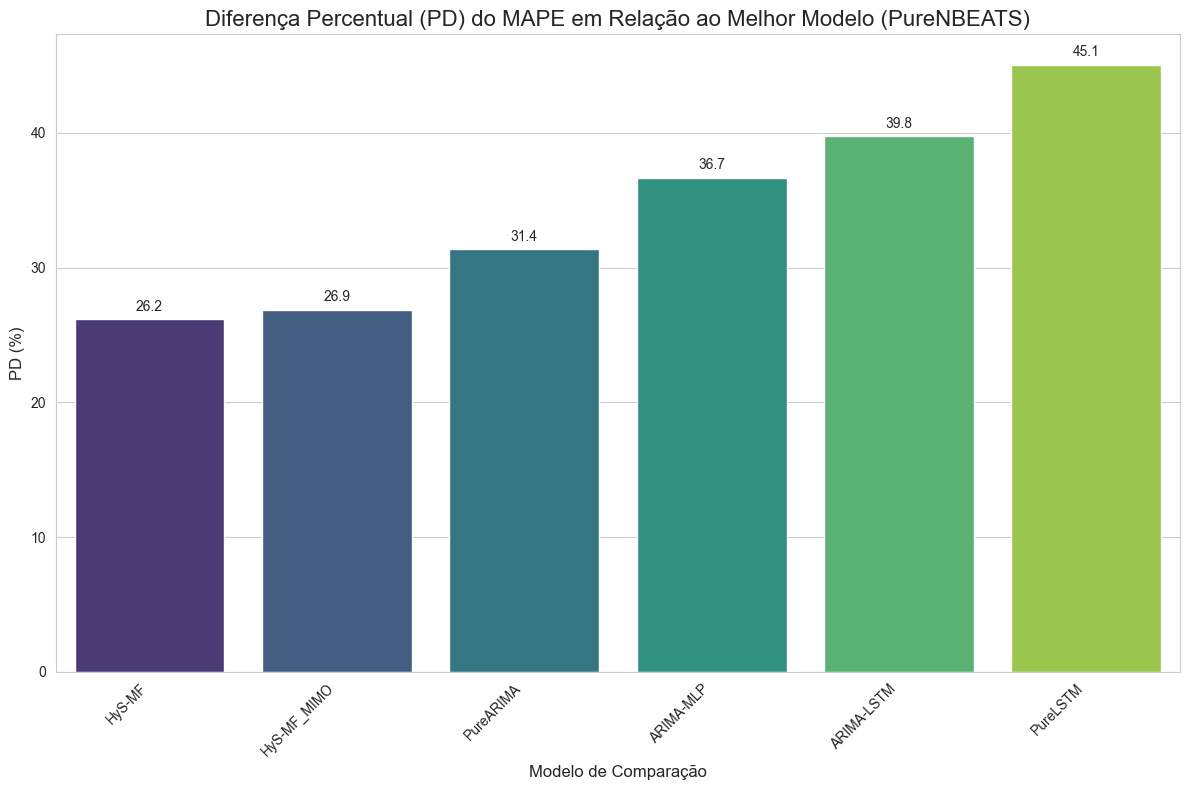

In [6]:
# Célula 5: Gráfico de Ganho Percentual (Similar à Figura 9)

# O DataFrame deve conter apenas os valores numéricos de MAPE, sem o '%' no final.

# Vamos recriar o df_mape numericamente para garantir
df_mape_numeric = df_metrics.map(lambda x: x.get('MAPE') if isinstance(x, dict) else None)

# 1. Calcular a média do MAPE para cada modelo em todos os datasets
mean_mapes = df_mape_numeric.mean()

# 2. Identificar o melhor modelo (aquele com o menor MAPE médio)
best_model_name = mean_mapes.idxmin()
best_model_mape = mean_mapes.min()

print(f"O melhor modelo em média foi: '{best_model_name}' com um MAPE médio de {best_model_mape:.2f}%")

# 3. Calcular a Diferença Percentual (PD) para todos os outros modelos
# Fórmula: PD = 100 * (MAPE_outro_modelo - MAPE_melhor_modelo) / MAPE_outro_modelo
# Esta fórmula é uma variação da do artigo para mostrar o ganho.
pd_results = {}
for model_name, mape_a in mean_mapes.items():
    if model_name != best_model_name:
        # Onde 'a' é o modelo de comparação e 'b' é o melhor modelo
        pd_value = 100 * (mape_a - best_model_mape) / mape_a
        pd_results[model_name] = pd_value

# 4. Preparar os dados para o gráfico
df_pd = pd.DataFrame.from_dict(pd_results, orient='index', columns=['PD(%)'])
df_pd_sorted = df_pd.sort_values(by='PD(%)', ascending=True)

# 5. Gerar o gráfico de barras
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x=df_pd_sorted.index, 
    y=df_pd_sorted['PD(%)'], 
    palette='viridis',
    hue=df_pd_sorted.index,  # Atribui a variável de 'x' para 'hue'
    legend=False             # Impede a criação da legenda redundante
)

plt.title(f'Diferença Percentual (PD) do MAPE em Relação ao Melhor Modelo ({best_model_name})', fontsize=16)
plt.ylabel('PD (%)', fontsize=12)
plt.xlabel('Modelo de Comparação', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotaciona os nomes dos modelos para não sobrepor
plt.tight_layout() # Ajusta o layout para caber tudo

# Adicionar os valores no topo das barras
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [7]:
# NOVA CÉLULA: Análise Estatística Global com Teste de Friedman


print("--- Análise Estatística Global com Teste de Friedman ---")

# 1. Preparar os dados: Usaremos o DataFrame numérico de MAPE que já temos.
# Certifique-se de que a célula que cria 'df_mape_numeric' foi executada.
try:
    # Vamos remover colunas ou linhas que tenham valores nulos, caso algum modelo tenha falhado
    df_mape_clean = df_mape_numeric.dropna()
    
    if len(df_mape_clean) < len(df_mape_numeric):
        print(f"Aviso: {len(df_mape_numeric) - len(df_mape_clean)} datasets foram removidos da análise por terem resultados ausentes.")
        
    print(f"\nDatasets considerados na análise: {list(df_mape_clean.index)}")

    # 2. Executar o Teste de Friedman
    stat, p_value = friedmanchisquare(*[df_mape_clean[col] for col in df_mape_clean.columns])

    print(f"\nResultado do Teste de Friedman:")
    print(f"Estatística do teste: {stat:.4f}")
    print(f"p-valor: {p_value:.4f}")

    # 3. Interpretar o resultado
    alpha = 0.05
    if p_value < alpha:
        print("\nConclusão: O p-valor é menor que 0.05. Rejeitamos a hipótese nula.")
        print(">> Existe uma diferença estatisticamente significativa no desempenho geral dos modelos.")
        
        # 4. Se houver diferença, realizar o Teste Post-hoc de Nemenyi
        # O teste de Nemenyi compara os modelos dois a dois para ver quais são diferentes.
        print("\n--- Teste Post-hoc de Nemenyi (para identificar as diferenças) ---")
        p_values_nemenyi = sp.posthoc_nemenyi_friedman(df_mape_clean)
        
        print("Tabela de p-valores das comparações par a par:")
        display(p_values_nemenyi)
        
        # 5. Visualizar com um Diagrama de Diferença Crítica (CD Diagram)
        # Esta é uma visualização padrão e de alto impacto para este tipo de teste.
        sp.sign_plot(p_values_nemenyi, k_star_meth='bonf')
        plt.title("Diagrama de Diferença Crítica (Teste de Nemenyi)", fontsize=14)
        plt.show()

    else:
        print("\nConclusão: O p-valor é maior que 0.05. Não podemos rejeitar a hipótese nula.")
        print(">> Não há evidência de uma diferença estatística significativa no desempenho geral dos modelos.")

except NameError:
    print("ERRO: O DataFrame 'df_mape_numeric' não foi encontrado. Execute a célula anterior que gera as tabelas de métricas.")

--- Análise Estatística Global com Teste de Friedman ---

Datasets considerados na análise: ['AirPassengers', 'Nile', 'Sunspots', 'UKgas', 'ukdriverdeaths']

Resultado do Teste de Friedman:
Estatística do teste: 7.1143
p-valor: 0.3104

Conclusão: O p-valor é maior que 0.05. Não podemos rejeitar a hipótese nula.
>> Não há evidência de uma diferença estatística significativa no desempenho geral dos modelos.


--- Análise Estatística Automatizada com autorank ---

Analisando 5 datasets e 7 modelos.
Rejecting null hypothesis that data is normal for column HyS-MF (p=0.000572<0.007143)
Rejecting null hypothesis that data is normal for column HyS-MF_MIMO (p=0.000768<0.007143)
Rejecting null hypothesis that data is normal for column ARIMA-MLP (p=0.000788<0.007143)
Rejecting null hypothesis that data is normal for column ARIMA-LSTM (p=0.000479<0.007143)
Rejecting null hypothesis that data is normal for column PureARIMA (p=0.000655<0.007143)
Fail to reject null hypothesis that data is normal for column PureLSTM (p=0.019020>=0.007143)
Rejecting null hypothesis that data is normal for column PureNBEATS (p=0.001543<0.007143)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.999575>=0.050000)
Using Friedman test as omnibus test
Fail to reject null hypothesis that there is no difference between the distributions (p=0.310407)
      

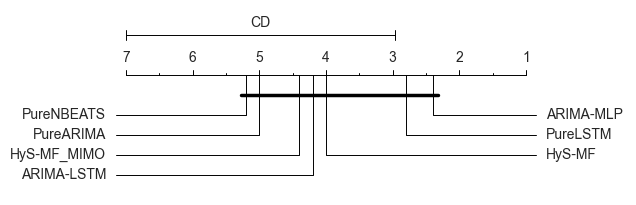

In [8]:
# NOVA CÉLULA: Análise Estatística Automatizada com autorank


print("--- Análise Estatística Automatizada com autorank ---")

# 1. Preparar os dados
# O autorank espera um DataFrame onde as colunas são os modelos e as linhas são os datasets.
# O nosso DataFrame 'df_mape_numeric' já está neste formato perfeito.
try:
    # Vamos usar o DataFrame de MAPE limpo que já criamos
    df_data = df_mape_numeric.dropna()
    print(f"\nAnalisando {len(df_data)} datasets e {len(df_data.columns)} modelos.")

    # 2. Executar o autorank
    # O autorank realiza o teste de Friedman e, se necessário, o teste post-hoc de Nemenyi.
    # Definimos alpha=0.05 e pedimos um relatório detalhado (verbose=True).
    result = autorank.autorank(df_data, alpha=0.05, verbose=True)
    
    # O objeto 'result' contém a análise completa.
    print("\n--- Relatório Gerado pelo autorank ---")
    print(result)

    # 3. Gerar o Gráfico de Diferença Crítica (CD Diagram)
    # Esta é a visualização mais poderosa gerada pela biblioteca.
    print("\n--- Gráfico de Diferença Crítica (CD Diagram) ---")
    autorank.plot_stats(result,allow_insignificant=True)
    plt.show()

except NameError:
    print("ERRO: O DataFrame 'df_mape_numeric' não foi encontrado. Execute a célula que gera as tabelas de métricas primeiro.")
except Exception as e:
    print(f"Ocorreu um erro durante a execução do autorank: {e}")